In [ ]:
cp -r ~/datasets/meetup/backup/CrudeOil .

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.1


# Load Data

In [2]:
data = pd.read_csv("CrudeOil/CL=F_daily.csv")
data.shape

(2517, 7)

In [3]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2011-04-25,112.339996,113.480003,111.080002,112.279999,112.279999,209683.0
1,2011-04-26,112.150002,112.639999,111.120003,112.209999,112.209999,234441.0
2,2011-04-27,111.889999,113.400002,110.709999,112.760002,112.760002,338697.0
3,2011-04-28,113.129997,113.970001,111.690002,112.860001,112.860001,301604.0
4,2011-04-29,112.820000,114.180000,112.250000,113.930000,113.930000,201831.0


# Remove NaN

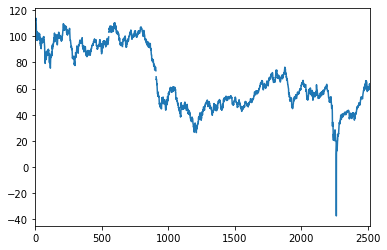

In [4]:
data.Close.plot()

In [5]:
pd.isna(data.Close).sum()

23

In [6]:
series = data.Close[~pd.isna(data.Close)]
time_str = data.Date[~pd.isna(data.Close)]
print(series.shape)

(2494,)


# Define Param

In [7]:
window_size = 14
delay = 10

# Split Train/Valid

In [8]:
train_ratio = 0.95
split_time = int(len(data)*train_ratio)
print("split_time_str: ", time_str.iloc[split_time])

split_time_str:  2020-11-19


In [80]:
x_train = series[:split_time]
x_valid = series[split_time-(window_size+delay):]
x_forcast = series[-window_size:]
print(x_train.shape, x_valid.shape, x_forcast.shape)

(2391,) (127,) (14,)


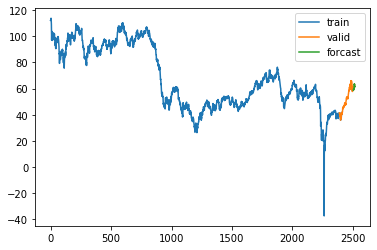

In [81]:
plt.plot(x_train, label="train")
plt.plot(x_valid, label="valid")
plt.plot(x_forcast, label="forcast")
plt.legend()

# Prepare Windowed Data

In [82]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer, delay=1, train=True):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + delay, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + delay))
    if train:
        dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:window_size], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)  
    return dataset

In [83]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [86]:
batch_size = 32
shuffle_buffer_size = 1000

time_str_train = time_str[(window_size+delay):split_time]
time_str_valid = time_str[split_time:]
print(time_str_train.shape, time_str_valid.shape)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size, delay=delay)
valid_set = windowed_dataset(x_valid, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size, delay=delay, train=False)

(2367,) (103,)


In [87]:
def check_data(dataset):
    count=0
    for i,(x,y) in enumerate(dataset):
        count+=x.shape[0]
        if i==0:
            print("x.shape: ", x.shape, ", y.shape: ", y.shape)
    print("#records: ", count)
    
check_data(train_set)
check_data(valid_set)

x.shape:  (128, 14) , y.shape:  (128,)
#records:  2368
x.shape:  (104, 14) , y.shape:  (104,)
#records:  104


# Train Model

In [16]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Lambda(lambda x: x / 100.0),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0),
  tf.keras.layers.Lambda(lambda x: tf.squeeze(x, axis=-1) ),
])

In [17]:
optimizer = tf.keras.optimizers.RMSprop(lr=1e-3)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, validation_data=valid_set, epochs=100)

Epoch 1/100
19/19 [==============================] - 3s 133ms/step - loss: 29.7096 - mae: 30.1770 - val_loss: 16.8296 - val_mae: 17.3296
Epoch 2/100
19/19 [==============================] - 1s 33ms/step - loss: 13.5417 - mae: 14.0238 - val_loss: 10.3852 - val_mae: 10.8852
Epoch 3/100
19/19 [==============================] - 1s 36ms/step - loss: 12.2281 - mae: 12.7150 - val_loss: 15.2034 - val_mae: 15.7034
Epoch 4/100
19/19 [==============================] - 1s 38ms/step - loss: 11.3692 - mae: 11.8666 - val_loss: 9.3402 - val_mae: 9.8402
Epoch 5/100
19/19 [==============================] - 1s 42ms/step - loss: 10.7795 - mae: 11.2691 - val_loss: 9.7929 - val_mae: 10.2929
Epoch 6/100
19/19 [==============================] - 1s 36ms/step - loss: 10.0093 - mae: 10.4974 - val_loss: 10.9787 - val_mae: 11.4787
Epoch 7/100
19/19 [==============================] - 1s 39ms/step - loss: 9.2061 - mae: 9.6960 - val_loss: 9.8303 - val_mae: 10.3303
Epoch 8/100
19/19 [==============================] - 

# Validation

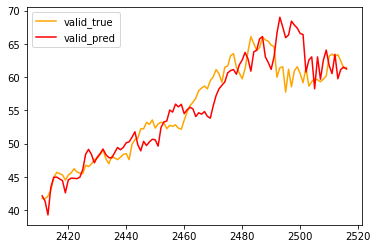

In [125]:
y_true = []
y_pred = []

for x,y in valid_set:
    #print(x.shape, y.shape)
    y_hat = model.predict(x)
    #print(y_hat.shape, y_hat.dtype)
    y_true += list(y)
    y_pred = list(y_hat)

time_index = list(x_valid[window_size+delay-1:].index)
plt.plot(time_index, y_true, label="valid_true",c="orange")
plt.plot(time_index, y_pred, label="valid_pred",c="red")
plt.legend()

In [89]:
time_str_valid

2412    2020-11-19
2413    2020-11-20
2414    2020-11-23
2415    2020-11-24
2416    2020-11-25
           ...    
2512    2021-04-16
2513    2021-04-19
2514    2021-04-20
2515    2021-04-21
2516    2021-04-22
Name: Date, Length: 103, dtype: object

# Forecast

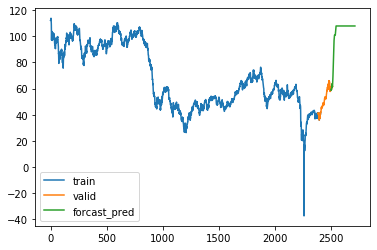

In [147]:
forcast_days = 200
forcast_data = list(x_forcast.values)
time_index = list(x_forcast.index)

for day in range(forcast_days):
    x = np.array(forcast_data[day:day+window_size])[np.newaxis]
    y_hat = model.predict(x)
    forcast_data.append(int(y_hat))
    time_index.append(time_index[-1]+1)


plt.plot(x_train, label="train")
plt.plot(x_valid, label="valid")
plt.plot(time_index, forcast_data, label="forcast_pred")
plt.legend()    


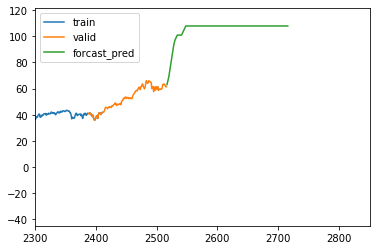

In [149]:
plt.plot(x_train, label="train")
plt.plot(x_valid, label="valid")
plt.plot(time_index[-forcast_days:], forcast_data[-forcast_days:], label="forcast_pred")
plt.xlim([2300,None])
plt.legend()  